In this part we are importing our libraries that we will use during our neural networks training (note that pandas will be used to turn the result to a csv file)

In [33]:
import numpy as np
import sys
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.python.keras.utils import np_utils
from keras.optimizers import SGD
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

np.random.seed(42)  


here we are setting some constants that we will use later in our training

In [5]:

DEFAULT_BATCH_SIZE = 32
DEFAULT_NUMBER_HIDDEN = 2
DEFAULT_LEARNING_RATE = 0.01
NUM_CLASSES = 10  
EPOCHS = 5
results = []


we are using the mnist dataset (minst is a dataset of 28x28 images of handwritten digits and their labels
) which we are loading from keras and then splitting it into train and test data


In [6]:
(X_train_1, train_labels_1), (X_test, test_labels_1) = mnist.load_data()


- Reshapes `X_train_1` and `X_test` to have 784 columns each, converting 2D image data into 1D vectors for model input.
- Converts data types to `float32` for both datasets to ensure compatibility with machine learning frameworks and optimize memory usage

In [7]:
X_train_1 = X_train_1.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train_1 = X_train_1.astype('float32')
X_test = X_test.astype('float32')

Normalizes the training and testing datasets to a range of 0 to 1 by dividing by 255, improving model training efficiency by ensuring inputs are on a consistent scale.

its divided bu 255 because image data typically comes in the form of integers ranging from 0 to 255, representing the intensity of pixels in grayscale images (or each color channel in RGB images).

In [8]:
X_train_1 /= 255
X_test /= 255

Splits the preprocessed dataset into a training set with the first 50,000 samples and a validation set with the last 10,000 samples. 

In [6]:
# Divides the dataset into train and validation sets
X_valid = X_train_1[50000:60000]
X_train = X_train_1[:50000]
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')

50000 train samples
10000 validation samples


The label arrays are converted into a format that's more suitable for the model using the `np_utils.to_categorical` function. This process changes the training and testing labels into one-hot encoded vectors, determined by the total number of classes (`NUM_CLASSES`). In one-hot encoding, for each label, an array is created where all elements are 0 except for the position corresponding to the label, which is set to 1.

Following this transformation for both training and testing labels, a subset of the training labels is allocated for validation purposes (`valid_labels`), extracted from the last 10,000 entries of the one-hot encoded training labels. Consequently, the `train_labels` array is adjusted to contain only the first 50,000 entries to align with the dataset's split for training, validation, and testing.


In [7]:
train_labels = np_utils.to_categorical(train_labels_1, NUM_CLASSES)
test_labels = np_utils.to_categorical(test_labels_1, NUM_CLASSES)
valid_labels = train_labels[50000:60000]
train_labels = train_labels[:50000]

The function `create_model` is designed to easily experiment with different architectures by adjusting the number of hidden layers, input shape, and number of output classes. It allows for quick adjustments and testing of various configurations, facilitating the exploration of multiple combinations of hidden layers, batch sizes, and learning rates in the model training process.

In [9]:
def create_model(num_hidden_layers, input_shape, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

here we are conducting a series of experiments to explore how different hyperparameters affect model performance. It iterates over sets of batch sizes, numbers of hidden layers, and learning rates, using a predefined function `create_model` to construct models with these varying configurations. For each configuration, the model is compiled and trained on a training set, then evaluated on a test set. The results, including hyperparameter values and model performance (accuracy and loss), are collected in a list and then converted into a DataFrame. This DataFrame is saved to a CSV file, `hyperparameter_tuning_results.csv`, allowing for easy analysis of how each hyperparameter impacts the model's effectiveness.


In [ ]:
for batch_num in [1, 2, 4, 8, 16, 32, 64, 128]:
    model = create_model(DEFAULT_NUMBER_HIDDEN, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=DEFAULT_LEARNING_RATE), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=batch_num, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=batch_num, verbose=1)

    results.append({'Hyperparameter': 'BatchSize', 
                    'Value': batch_num, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]}) 

for hidden_num in [1, 2, 4, 6, 8]:
    model = create_model(hidden_num, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=DEFAULT_LEARNING_RATE), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=DEFAULT_BATCH_SIZE, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=DEFAULT_BATCH_SIZE, verbose=1)
    results.append({'Hyperparameter': 'NumHiddenLayers', 
                    'Value': hidden_num, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]})

for learning_r in [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]:
    model = create_model(DEFAULT_NUMBER_HIDDEN, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_r), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=DEFAULT_BATCH_SIZE, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=DEFAULT_BATCH_SIZE, verbose=1)
    results.append({'Hyperparameter': 'LearningRate', 
                    'Value': learning_r, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]})

df = pd.DataFrame(results)

df.to_csv('hyperparameter_tuning_results.csv', index=False)


Loaded the tuning results into a DataFrame and picked out the batch sizes, hidden layer counts, accuracy, and loss. Made a grid over batch sizes and hidden layers and used it to guess accuracy and loss in between our actual data points. Started a plot to show this visually.

Looking at the plots, it's clear that upping the batch size improves accuracy and decreases loss until it hits a plateau around the 20-40 mark. Past that, cranking up the batch size doesn't make much of a dent. As for hidden layers, there's a point of diminishing returns there too, once you have a good amount, adding extra doesn't seem to boost performance. And about learning rate—there isn't a drastic change in accuracy with different rates, suggesting that once you nail the batch size and hidden layers, the learning rate can be fine-tuned for potentially better results, but it's not the main player.


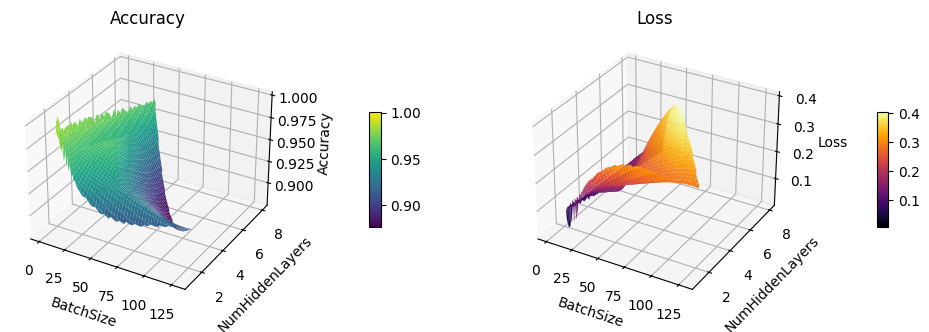

In [34]:
df = pd.read_csv('hyperparameter_tuning_results.csv')  


x = df['BatchSize']
y = df['NumHiddenLayers']
z = df['LearningRate']
z1 = df['Accuracy']
z2 = df['Loss']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

zi1 = griddata((x, y), z1, (xi, yi), method='cubic')
zi2 = griddata((x, y), z2, (xi, yi), method='cubic')

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(xi, yi, zi1, cmap='viridis', edgecolor='none')
ax1.set_title('Accuracy')
ax1.set_xlabel('BatchSize')
ax1.set_ylabel('NumHiddenLayers')
ax1.set_zlabel('Accuracy')
fig.colorbar(surf1, ax=ax1, shrink=0.25, aspect=10, pad = 0.2)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(xi, yi, zi2, cmap='inferno', edgecolor='none')
ax2.set_title('Loss')
ax2.set_xlabel('BatchSize')
ax2.set_ylabel('NumHiddenLayers')
ax2.set_zlabel('Loss')
fig.colorbar(surf2, ax=ax2, shrink=0.25, aspect=10 , pad = 0.2)

# another plot for learning rate

plt.show()
